In [1]:
import pandas as pd
import tarfile
from tqdm import tqdm
import json
import numpy as np
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.utils import to_categorical
from transformers import RobertaTokenizer, BertTokenizer, TFRobertaModel
import implicit
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import tensorflow as tf


In [2]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
numpyArray = np.load('../Jiro/features.npy')
np.load = np_load_old
ratings_ = df = pd.DataFrame(numpyArray, columns = ['user_id','business_id','stars','text'])

In [3]:
ratingsnew = ratings_.head(5000)
ratingsnew["stars"].astype(float).round()

for count in range(len(ratingsnew.text)):
    ratingsnew.at[count, 'text'] = " ".join(ratingsnew.at[count, 'text'])

ratingsnew['text'] = ratingsnew['text'].astype(str)
print(ratings_.head(1000))


                    user_id             business_id stars  \
0    mh_-eMZ6K5RLWhZyISBhwA  XQfwVwDr-v0ZS3_CbbE5Xw   3.0   
1    OyoGAe7OKpv6SyGZT5g77Q  7ATYjTIgM3jUlt4UM3IypQ   5.0   
2    8g_iMtfSiwikVnbP2etR0A  YjUWPpI6HXG530lwP-fb2A   3.0   
3    _7bHUi9Uuf5__HHc_Q8guQ  kxX2SOes4o-D3ZQBkiMRfA   5.0   
4    bcjbaE6dDog4jkNY91ncLQ  e4Vwtrqf-wpJfwesgvdgxQ   4.0   
..                      ...                     ...   ...   
995  syyKcKPFILDysHWmtka-aA  1_hDCN3iioFR3XnUr32ZtA   5.0   
996  _lgLNzpzf3qmbwySBakxEw  5RzJ2bjU8bLSaN5SuiUpYA   4.0   
997  Sh_vUlHHY2Kuj14eF8NYZQ  s1PNBO9o5jIgNd5YWUDLXQ   5.0   
998  YwMD-AVT67fmYRGxnlRSPA  alUk6OwNhofyc90NDMDY-Q   5.0   
999  WKe2b_EeLBnZ3lZV5WKYGQ  -Or44IdY51Ukd618kikmtA   4.0   

                                                  text  
0    [CLS] If you decide to eat here , just be awar...  
1    [CLS] I ' ve taken a lot of spin classes over ...  
2    [CLS] Family diner . Had the b ##uff ##et . E ...  
3    [CLS] Wow ! Yu ##mmy , different ,

C:\Users\apran\AppData\Local\Temp\ipykernel_24604\4289126749.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratingsnew['text'] = ratingsnew['text'].astype(str)


In [4]:
# df_features = df_ratings.pivot_table(
#     index = "user_id",
#     columns = "business_id",
#     values = "labels",
# ).fillna(0)
df_features = ratingsnew
df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes

C:\Users\apran\AppData\Local\Temp\ipykernel_24604\1422376793.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["user_id"]  = df_features['user_id'].astype("category").cat.codes
C:\Users\apran\AppData\Local\Temp\ipykernel_24604\1422376793.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["business_id"]  = df_features['business_id'].astype("category").cat.codes


In [5]:

sparse_item_user = sparse.csr_matrix((df_features['stars'].astype('float'), (df_features['user_id'], df_features['business_id'])))
sparse_user_item = sparse.csr_matrix((df_features['stars'].astype('float'),  (df_features['business_id'],df_features['user_id'])))

In [6]:
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)


alpha_val = 40
data_conf = (sparse_item_user * alpha_val).astype('double')


model.fit(data_conf)

c:\Users\apran\anaconda3\envs\nlp\lib\site-packages\implicit\utils.py:33: UserWarning: Intel MKL BLAS detected. Its highly recommend to set the environment variable 'export MKL_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

In [7]:
df_features["labels"] = df_features.apply(lambda row: model.user_factors[row['user_id']],axis=1)
df_features.head()

C:\Users\apran\AppData\Local\Temp\ipykernel_24604\2474429966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features["labels"] = df_features.apply(lambda row: model.user_factors[row['user_id']],axis=1)


,user_id,business_id,stars,text,labels
0,3819,1410,3.0,"[CLS] If you decide to eat here , just be awar...","[1.8323742, -1.2629781, -0.39135513, -1.159273..."
1,1986,364,5.0,[CLS] I ' ve taken a lot of spin classes over ...,"[1.7015097, 1.2990336, 1.6027317, -2.383277, -..."
2,703,1462,3.0,[CLS] Family diner . Had the b ##uff ##et . E ...,"[-0.9895955, 1.2555463, -0.07535086, 0.4605960..."
3,2803,2042,5.0,"[CLS] Wow ! Yu ##mmy , different , delicious ....","[-0.33410296, -0.2211181, -1.3168167, -0.83620..."
4,3005,1732,4.0,[CLS] Cut ##e interior and owner ( ? ) gave us...,"[1.5847893, 0.3352556, 0.8130566, 1.9218826, 1..."


In [8]:
train_df, test_df = train_test_split(df_features, test_size = 0.2)
y_train = tf.convert_to_tensor(
    train_df["labels"].tolist(), dtype=float
)

y_test = tf.convert_to_tensor(
    test_df["labels"].tolist(), dtype=float
)

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
roberta = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [10]:
x_train = tokenizer(
    text=train_df.text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=test_df.text.tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [11]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

In [12]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

In [13]:
max_len = 70
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = roberta(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)
y = Dense(20,activation = 'sigmoid')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [14]:
optimizer = Adam(
    learning_rate=5e-05, 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [15]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=2,
    batch_size=36
)

Epoch 1/2


c:\Users\apran\anaconda3\envs\nlp\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


112/112 [==============================] - 490s 4s/step - loss: 30.3941 - balanced_accuracy: 0.0417 - val_loss: 38.3342 - val_balanced_accuracy: 0.0440
Epoch 2/2
112/112 [==============================] - 424s 4s/step - loss: 51.1484 - balanced_accuracy: 0.0435 - val_loss: 61.3225 - val_balanced_accuracy: 0.0440


In [16]:
predicted_raw = model.predict({'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']})
predicted_raw[0]

125/125 [==============================] - 244s 2s/step


array([9.7457671e-01, 1.0000000e+00, 1.0000000e+00, 9.0238637e-01,
       1.0000000e+00, 1.0000000e+00, 9.9860203e-01, 9.9999970e-01,
       9.4161469e-01, 1.0000000e+00, 9.9999672e-01, 6.5124571e-02,
       1.0000000e+00, 9.6088445e-01, 3.8846778e-05, 1.0000000e+00,
       9.9991876e-01, 1.2208761e-01, 1.0000000e+00, 4.7819450e-02],
      dtype=float32)

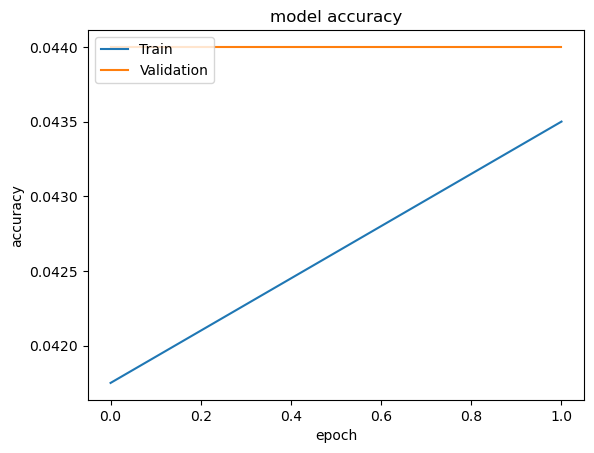

In [17]:
plt.plot(train_history.history['balanced_accuracy'])
plt.plot(train_history.history['val_balanced_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
df_ratings = ratings_.head(1000)

In [19]:
df_features['labels'].min()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
user_id =  2
model.user_factors[1]


array([-1.3869247 , -0.04471998, -0.5495489 , -1.0993285 , -1.7117126 ,
        1.8766447 ,  1.0392677 ,  0.45267007,  2.4222846 , -1.8598964 ,
        1.0478249 , -0.6633702 ,  1.3949038 ,  1.2315414 ,  0.77544826,
        1.3835194 ,  0.37806535,  1.108001  ,  1.999737  , -0.6534094 ],
      dtype=float32)